In [2]:
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(1, '../')

import matplotlib.pyplot as plt
from os import path

from deployment_instance import ExperimentResult
from src.ingest_data import ingest_experiment_results
from src.query_data import get_data_exfiltration_times, get_data_exfiltration_cdf
from statistics import mean
import seaborn as sns

import pandas as pd

In [4]:
# Baseline attacker
bfs_layered_d10_h50 = ingest_experiment_results(path.join('data/Layered/ICS/bfs_layered_d10_h50'))
dfs_layered_d10_h50 = ingest_experiment_results(path.join('data/Layered/ICS/dfs_layered_d10_h50'))
targeted_layered_d10_h50 = ingest_experiment_results(path.join('data/Layered/ICS/targeted_layered_d10_h50'))

In [33]:
critical_hosts = ['control-host-0', 'control-host-1', 'control-host-2', 'control-host-3', 'control-host-4']

def get_control_host_capture_times(data: dict[str, ExperimentResult], experiment_name: str):
    df = pd.DataFrame(
        columns=[
            "experiment_name",
            "experiment_id",
            "time_infected",
            "host_num",
            "host_percentage_infected",
        ]
    )
        
    for exp_id, result in data.items():
        capture_times = []
        for host in result.hosts_infected:
            if host.name in critical_hosts:
                capture_times.append(host.time_infected)
        # sort the capture times
        capture_times.sort()
        for idx, time in enumerate(capture_times):
            df.loc[df.shape[0]] = [
                experiment_name,
                exp_id,
                time / 60,
                idx + 1,
                idx / (len(critical_hosts) - 1),
            ]

    return df

In [44]:
bfs_df = get_control_host_capture_times(bfs_layered_d10_h50, "bfs_layered_d10_h50")
dfs_df = get_control_host_capture_times(dfs_layered_d10_h50, "dfs_layered_d10_h50")
targeted_df = get_control_host_capture_times(targeted_layered_d10_h50, "targeted_layered_d10_h50")

all_data = pd.concat([bfs_df, dfs_df, targeted_df])

/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


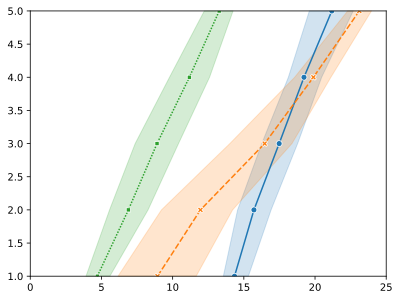

In [47]:
ax = sns.lineplot(data=all_data, 
             x="time_infected", y="host_num", hue="experiment_name",
             style="experiment_name", markers=True, dashes=True, legend=False, orient="y")
# Remove x-axis label
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_xlim(0, 25)

# Save as svg
plt = ax.get_figure()
plt.savefig('./plots/ics_targeted_times.svg', transparent=True)

In [6]:
# Print the mean time to exfiltrate
print("Mean time to exfiltrate: ")
print("Standalone: ", mean(baseline_standalone_d0_h0_times['time_exfiltrated']))
print("Standalone: ", mean(baseline_standalone_d10_h50_times['time_exfiltrated']))
print("% Increase: ", (mean(baseline_standalone_d10_h50_times['time_exfiltrated']) / mean(baseline_standalone_d0_h0_times['time_exfiltrated']) - 1) * 100)
print("Layered: ", mean(baseline_layered_d10_h50_times['time_exfiltrated']))
print("% Increase: ", (mean(baseline_layered_d10_h50_times['time_exfiltrated']) / mean(baseline_standalone_d0_h0_times['time_exfiltrated']) - 1) * 100)
print("% Increase: ", (mean(baseline_layered_d10_h50_times['time_exfiltrated']) / mean(baseline_standalone_d10_h50_times['time_exfiltrated']) - 1) * 100)

Mean time to exfiltrate: 
Standalone:  40.042714812854925
Standalone:  44.06876642862956
% Increase:  10.054392252350851
Layered:  53.157308268547055
% Increase:  32.7515092744959
% Increase:  20.623544919589733
